One of Telco's main problems is customer churn. Is it possible to predict that the customer will churn before the churn happens?
----




download dataset to your local instance:

In [ ]:
!wget https://raw.githubusercontent.com/MauroDNapoli/churn-prediction/main/WA_Fn-UseC_-Telco-Customer-Churn.csv

download and install libraries:

In [ ]:
!wget https://raw.githubusercontent.com/MauroDNapoli/churn-prediction/main/requirements.txt
!pip install -r requirements.txt

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, \
                            precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [5]:
def find_nearest(array: np.array, value: np.float):
    """
    return the index of the nearest value 
    to the input value in the array
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

Load Data
-----

In [6]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
print(f"The dataset has a total of {len(df)} rows.")

The dataset has a total of 7043 rows.


Split train-test
-----

 - We are going to use 15% of the dataset for testing purposes.
 - As the class distribution is unbalanced we need to make sure we have the same proportion of each class in the train and test set.

In [42]:
X = df[df.columns[:-1]]  # keep all the features columns
y = df[df.columns[-1]]  # target column
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15)

In [43]:
for train_index, test_index in sss.split(X, y):
    X_train = X[X.index.isin(train_index)]
    y_train = y[y.index.isin(train_index)]
    X_test = X[X.index.isin(test_index)]
    y_test = y[y.index.isin(test_index)]

Fit scikit-learn model
----

#### 
- To approach this problem we decided to fit three different models. Logistic Regression, Random Forest and Gradient Boosting.
- We chose three different models based, with different complexity. Logistic Regression is the simplest and Gradient Boosting is the most complex.
- For searching the best hyperparameters we defined one different grid for each model and applied Randomize search to choose the best ones.
- We divide categorical and continuous features and apply a different type of preprocessing to each of them.

#### What metrics did we choose? Why? 

- We chose two different metrics to decide which model is the best one; **F1 score**, **balanced accuracy** and **average precision recall**, as false positive (FP) and false negative (FN) are crucial. Specially the latter.

#### Separate the columns type 

In [44]:
continuous_columns = ['MonthlyCharges', 'TotalCharges']

categorical_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                       'PaymentMethod']

#### Define the parameters grid for both models

In [68]:
param_grid_lr = {'model__penalty': ["l1", "l2"], # Type of regularization, use to penalize the outliers
              'model__C': [0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.9, 1], # How much regularization should we use
              'model__solver': ["newton-cg", "lbfgs", "liblinear", "sag"] # Solver to find the best parameters
             }

param_grid_rf = {'model__max_features': ["sqrt", "log2"], # How many features will each tree use
              'model__min_samples_leaf': [3, 4, 5, 6, 7, 8, 9, 10], # How many samples each leaf will have, if it's too low there are overfitting risks
              'model__max_depth': [None, 1, 2, 3, 5, 7, 8, 9, 10], # Depth of each tree, more depth, more changes of overfitting
              'model__n_estimators': [100, 120, 140, 160, 180] # Number of trees in the forest
             }

param_grid_gb = {'model__max_features': ["sqrt", "log2"], # How many features will each tree use
              'model__min_samples_leaf': [3, 4, 5, 6, 8, 9, 10], # How many samples each leaf will have, if it's too low there are overfitting risks
              'model__max_depth': [None, 1, 2, 3, 5, 8, 9, 10], # Depth of each tree, more depth, more changes of overfitting
              # 'model__loss': ["deviance", "exponential"], # Which loss function to use
              'model__min_samples_split': [3, 4, 5, 7, 8, 9, 10], # The minimum number of samples to split a node
              'model__n_estimators': [100, 120, 140, 160] # Number of trees in the forest
             }

#### Fit the different pipelines and search the best hyperparams using RandomizedSearchCV

/usr/local/Caskroom/miniconda/base/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 64 is smaller than n_iter=125. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


The F1 score for LogisticRegression is: 0.56
The balanced_accuracy score for LogisticRegression is: 0.72
The average_precision_recall score for LogisticRegression is: 0.69
The best params for LogisticRegression are: 
{'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__C': 0.1}
------------------------------------------------------------
The F1 score for RandomForestClassifier is: 0.57
The balanced_accuracy score for RandomForestClassifier is: 0.72
The average_precision_recall score for RandomForestClassifier is: 0.66
The best params for RandomForestClassifier are: 
{'model__n_estimators': 180, 'model__min_samples_leaf': 10, 'model__max_features': 'sqrt', 'model__max_depth': 10}
------------------------------------------------------------
The F1 score for GradientBoostingClassifier is: 0.64
The balanced_accuracy score for GradientBoostingClassifier is: 0.75
The average_precision_recall score for GradientBoostingClassifier is: 0.69
The best params for GradientBoostingClassifie

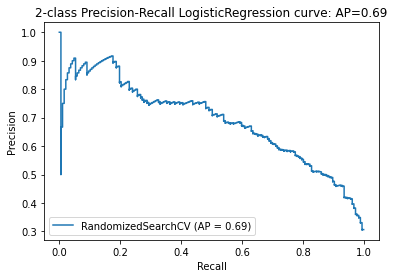

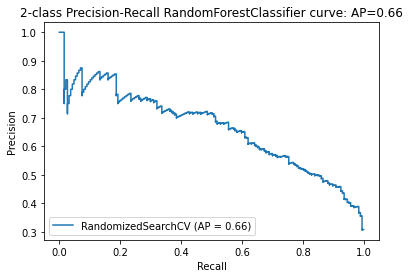

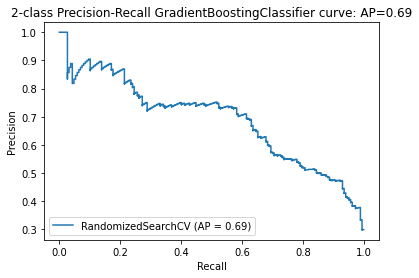

In [69]:
models = [(LogisticRegression(class_weight={0:1,1:10}), param_grid_lr),
          (RandomForestClassifier(class_weight={0:1,1:10}), param_grid_rf),
          (GradientBoostingClassifier(), param_grid_gb)]

# turn labels from 'No', 'Yes' to [0,1]
le = LabelEncoder()
le.fit(y_train)


cat_pipe = Pipeline([('OHE', OneHotEncoder(handle_unknown='ignore'))])

continuous_pipe = Pipeline([('HandleMissing', SimpleImputer(strategy='mean')), 
                            ('scaler', StandardScaler())
                           ])

preprocess = ColumnTransformer([('categorical', cat_pipe, categorical_columns),
                                ('continuous', continuous_pipe, continuous_columns)
                               ])
all_models = []
for model, param_grid in models:
    pipe = Pipeline([('preprocessing', preprocess),
                     ('model', model)
                    ])

    random_cv = RandomizedSearchCV(estimator = pipe,
                                   param_distributions=param_grid,
                                   n_iter = 125,
                                   cv=5,
                                   scoring="average_precision",
                                   n_jobs=-1)

    random_cv.fit(X_train, le.transform(y_train))
    model_name = type(model).__name__
    all_models.append(random_cv) #  Save model for later
    y_pred = random_cv.predict(X_test)
    y_score = random_cv.predict_proba(X_test)
    
    score = f1_score(le.transform(y_test), y_pred)
    print(f"The F1 score for {model_name} is: %.{2}f" % score)
    
    b_score = balanced_accuracy_score(le.transform(y_test), y_pred)
    print(f"The balanced_accuracy score for {model_name} is: %.{2}f" % b_score)

    average_precision = average_precision_score(le.transform(y_test), y_score[:, 1])
    print(f"The average_precision_recall score for {model_name} is: %.{2}f" % average_precision)
    print(f"The best params for {model_name} are: \n{random_cv.best_params_}")
    
    disp = plot_precision_recall_curve(random_cv, X_test, le.transform(y_test))
    disp.ax_.set_title("2-class Precision-Recall {0} curve: AP={1:0.2f}".format(model_name, average_precision));
    print("------------------------------------------------------------")

- We think it is important to plot the precision recall curve as with that information the business expert can decide which is the best precision-recall trade-off and chose a threshold based on that decision.

Altough the three models metrics are quite similar, Gradient Boosting is the model with the highest metrics overall. In a first instance, we will choose the Gradient Boosting Classifier as the best model.

#### The best model is Gradient Boosting Classifier with the following parameters:
{'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_features': 'sqrt', 'model__max_depth': 3, 'model__loss': 'exponential'}

In [71]:
all_models[2].best_params_

{'model__n_estimators': 100,
 'model__min_samples_split': 5,
 'model__min_samples_leaf': 4,
 'model__max_features': 'sqrt',
 'model__max_depth': 3}

### Best model pipeline:

In [54]:
print(all_models[2].best_estimator_)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('OHE',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'tenure', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'Streamin

## Conclusions and results

### Feature importance:

#### It is important for the business to know which are the most relevant features that explain customer churn.

In [48]:
# Get permutation importance of features
result = permutation_importance(all_models[2].best_estimator_, X_test, le.transform(y_test), n_repeats=10)

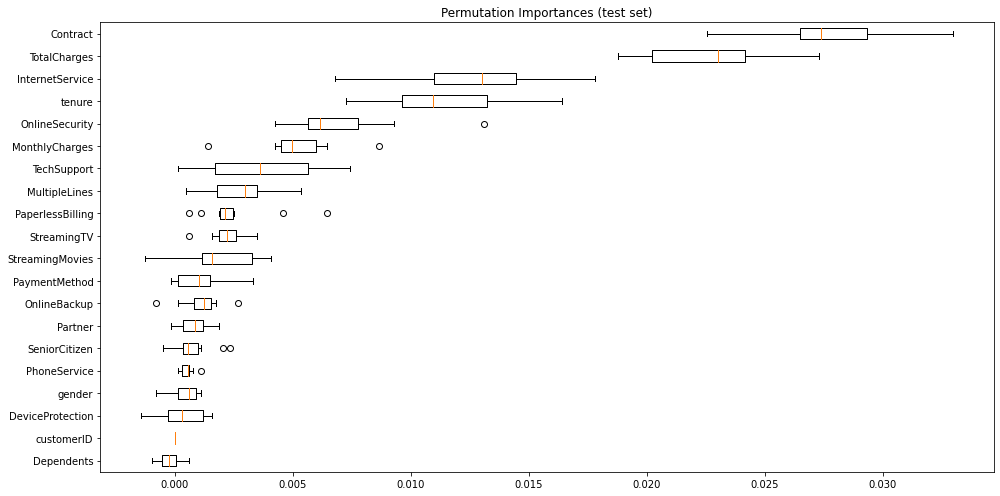

In [73]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(14,7))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

We can see that Contract, totalCharges, tenure, InternetService and OnlineSecurity are the 5 most important features.

### Recommendation:

#### As we don't know what the business wants, we can recommend what recall to choose. We suppose that the business wants to have a high recall with a low number of false positives for this step.

#### We recommend a recall of 90% in order to prevent almost every possible churn.

In [64]:
y_score = all_models[2].predict_proba(X_test)

In [65]:
precision, recall, thresholds = precision_recall_curve(le.transform(y_test), y_score[:, 1])

In [66]:
recall_desired = 0.9
idx = find_nearest(recall, recall_desired)

In [67]:
print("for a recall of {0:0.2f}, we should set a threshold of: {1:0.2f} and we will get an precision of: {2:0.2f}".format(recall[idx], thresholds[idx], precision[idx]))

for a recall of 0.90, we should set a threshold of: 0.19 and we will get an precision of: 0.47


### One line recommendation for the business:

#### This means that we setting a threshold of 0.19 we can identify 90% of the customers that are going to churn with a precision of 47%.

### Step by step summary:
- Load the data and do a quick analysis of the data and features available.
- Choose a research question.
- preprocess and do feature engineering over each column.
- Decide which were the best metrics to address this problem.
- Choose two different models to fit using RandomizedSearchCV for finding the best hyperparameters.
- Fit the different models unsing n_fold = 5 and compare three models metrics.
- Choose the best model and give business recommendations based on that model.

### Next steps:
- Discuss with the business which are their expectations regarding false positive and false negatives.
- Train a new model removing the least important features and compare perfomance against our current best_model. A model with less features is easier to maintain.
- Try to boost performance using a model ensemble.